In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

In [2]:
from quasinet.qnet import load_qnet
from quasinet.qsampling import qsample

diss = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_ff/random_order_disson_1.pkl"
)

samps = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_ff/random_order_samples_1.pkl"
)

model = load_qnet(
    "disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_1.joblib.gz",
    gz=True,
)

In [8]:
def _diss_linear(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(1)

    return np.array(diss)


def _actual_sample_dissonance(
    data_sample, diss_models, diss_fcn, order, length, missing_value=0
):
    if order is None:
        order = range(length)

    sample = np.full(length, "", dtype="<U21")

    diss = [list() for model in diss_models]

    # print(data_sample)

    for i in order:
        if data_sample[i] == "":
            sample[i] = "missing"
        else:
            sample[i] = data_sample[i]
        # [print(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]
        for d, model in zip(diss, diss_models):
            d.append(diss_fcn(sample, model, missing_value))
        # [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(
    data_samples, diss_models, diss_fcn, order, length, missing_value=0
):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length, missing_value
        )
        # print(len(diss), len(diss[0]), len(diss[0][8]), diss[0][8])
        # print(len(diss), len(diss[0]), len(diss[0][4]), diss[0][4])
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances

In [3]:
d = samps["qsampled"]

In [6]:
resampled = np.array([qsample(s, model, 1000) for s in tqdm(d)])

  0%|          | 0/100 [00:00<?, ?it/s]

compare resampled dissonances with actual (from dissonance matrix)

In [ ]:
resampled_diss

In [9]:
resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, range(390), 390
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# resampled_diss[dissonances(not samples)][subject][model][questions]
resampled = pd.DataFrame(_dissonance_data_at_question(resampled_diss[1], 10)).assign(
    y="resampled"
)

In [ ]:
pd.concat()

In [44]:
actual_diss = pd.read_csv(
    "disson_global/core/disson_global_core_with_actual_ff/random_order_dissonance_matrix_1.csv",
    index_col=0,
)

In [47]:
resampled_final_diss = pd.DataFrame(
    np.array([resampled_diss[1][subj][0][-1] for subj in range(100)])
).set_axis(actual_diss.columns, axis="columns")

In [55]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [91]:
questions = 10
resampled = pd.DataFrame(
    _dissonance_data_at_question(resampled_diss[1], questions)
).assign(y="resampled")

pd.concat(
    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).iloc[:, np.r_[:questions, -1]],
        resampled,
    ]
)

,0,1,2,3,4,5,6,7,8,9,y
0,0.000000,0.000000,0.554217,0.635294,0.0,0.0,0.095745,0.000000,0.333333,0.9,qsampled
1,0.726619,0.000000,0.084337,0.117647,0.0,0.0,0.531915,0.692308,0.444444,0.3,qsampled
2,0.000000,0.000000,0.554217,0.000000,0.0,0.0,0.000000,0.153846,0.358025,0.3,qsampled
3,0.726619,0.000000,0.000000,0.000000,0.0,0.0,0.531915,0.153846,0.333333,0.3,qsampled
4,0.726619,0.794118,0.554217,0.117647,0.0,0.0,0.276596,0.000000,0.753086,0.9,qsampled
...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.867257,0.000000,0.0,resampled
96,0.571429,0.111111,0.000000,0.740053,0.0,0.0,0.478632,0.000000,0.000000,0.0,resampled
97,0.000000,0.000000,0.000000,0.740053,0.0,0.0,0.000000,0.000000,0.000000,0.0,resampled
98,0.571429,0.111111,0.000000,0.740053,0.0,0.0,0.478632,0.000000,0.726619,0.0,resampled


In [92]:
for i in tqdm(range(1)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, 1000) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(390), 390
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, 390))
    ]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

In [93]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 390)
        for i in range(1)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

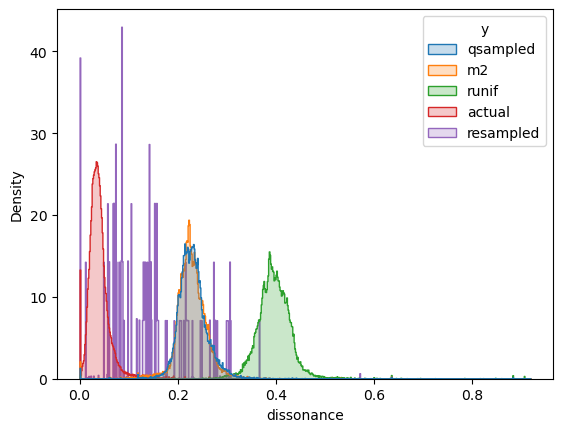

In [94]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

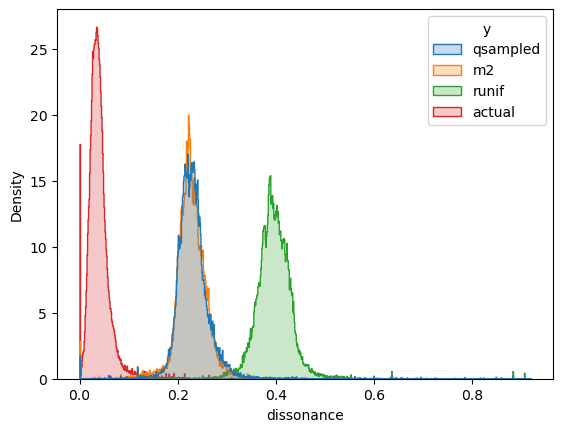

In [97]:
fig, ax = plt.subplots()
sns.histplot(
    dd.query('y!="resampled"').reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [99]:
nquestions = 390
qsample_steps = 2500

for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, qsample_steps) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(nquestions), nquestions
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, nquestions))
    ]

dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, nquestions)
        for i in range(1)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
nquestions = 390
qsample_steps = 5000

for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, qsample_steps) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(nquestions), nquestions
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, nquestions))
    ]

dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, nquestions)
        for i in range(1)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [ ]:
[
    _diss_dataset(
        disson, questions, groups=["qsampled", "m2", "runif", "actual"]
    ).to_csv(
        f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions}.csv",
        index=False,
    )
    for questions in range(1, 390)
]

In [63]:
groups = ["actual"]

questions_asked = 390
data = _diss_dataset(diss, questions_asked, groups=groups)

datad = data.iloc[:, np.r_[:questions_asked]].set_axis(
    actual_diss.columns, axis="columns"
)

<AxesSubplot:xlabel='value', ylabel='Density'>

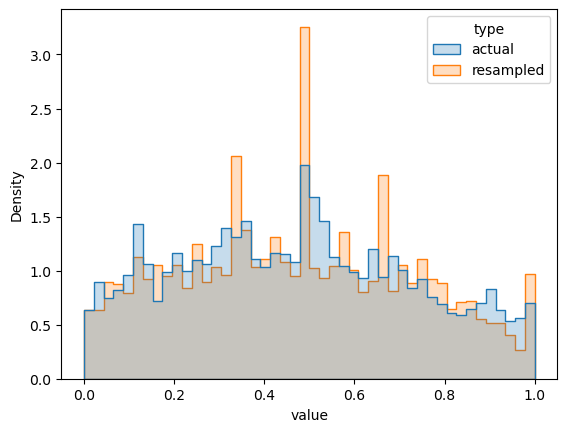

In [69]:
comb = pd.melt(
    pd.concat(
        [
            datad.assign(type="actual"),
            resampled_final_diss.assign(type="resampled"),
        ]
    ),
    id_vars="type",
)

sns.histplot(
    comb.query("value > 0"),
    x="value",
    element="step",
    stat="density",
    hue="type",
    common_norm=False,
    kde=False,
)

In [71]:
for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in range(1, 390)
    ]

  0%|          | 0/4 [00:00<?, ?it/s]

In [72]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 345)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

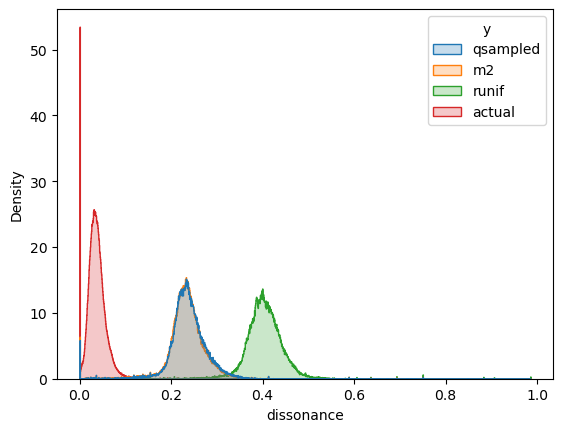

In [73]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [75]:
dd.query("y=='actual'")

,dissonance,y,questions
300,0.000000,actual,1
301,0.000000,actual,1
302,0.000000,actual,1
303,0.117647,actual,1
304,0.117647,actual,1
...,...,...,...
1531,0.045066,actual,344
1532,0.033017,actual,344
1533,0.036635,actual,344
1534,0.035962,actual,344


In [70]:
from pathlib import Path

for i in range(4):
    Path(f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/").mkdir(
        parents=True, exist_ok=True
    )